In [1]:
# --- 1. Install dependencies (run in Colab cell) ---
!pip install -qq polars py_vncorenlp transformers torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu124

ERROR: Could not find a version that satisfies the requirement py_vncorenlp (from versions: none)
ERROR: No matching distribution found for py_vncorenlp


In [ ]:
# --- 2. Imports and Setup ---
import os
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

import polars as pl
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from torch.nn import functional as F
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def seed_everything(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


seed_everything(42)
sample_size = 10000
bert_models = {
    "base": "google-bert/bert-base-uncased",
    "phobert": "vinai/phobert-base-v2",
    "vibert": "FPTAI/vibert-base-cased",
    "visobert": "uitnlp/visobert",
}
class_names = ["Negative", "Neutral", "Positive"]

output_name = "base"
tokenizer = AutoTokenizer.from_pretrained(bert_models[output_name])
model = AutoModel.from_pretrained(bert_models[output_name])


In [14]:
raw_df = (
    pl.read_parquet(
        "hf://datasets/khangnghiem/public/transform/company_reviews/2025-04-24_transformed_company_reviews.parquet"
    )
    .filter(pl.col("segmented_review").is_not_null())
    .with_columns(
        [
            pl.col("segmented_review")
            .map_elements(lambda x: " ".join(x), return_dtype=pl.Utf8)
            .alias("segmented_review"),
            pl.col("review_rating")
            .map_elements(
                lambda x: 0 if x <= 2 else 1 if x == 3 else 2, return_dtype=pl.Int32
            )
            .alias("review_rating"),
        ]
    )
)
df = raw_df.sample(shuffle=True, n=sample_size, seed=42)
print(len(raw_df))
print(len(df))
print(df["segmented_review"][0])


180421
10000
Nơi làm_việc của tôi . Cải_tiến liên_tục về công_nghệ và quản_lý .. Tôi mong_muốn góp_phần phát_triển các doanh_nghiệp CNTT tại Việt_Nam và đưa Việt_Nam trở_thành trung_tâm công_nghệ của thế_giới .


In [18]:
df.group_by("review_rating").agg(pl.count()).sort("review_rating").plot.bar(
    x="review_rating",
    y="count",
)


/var/folders/ds/qgc7ldz113jb3ym8xw9kxxmh0000gn/T/ipykernel_39479/965398092.py:1: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  df.group_by("review_rating").agg(pl.count()).sort("review_rating").plot.bar(


alt.Chart(...)

In [4]:
# --- 4. Tokenizer and Dataset ---
class CompanyReviewDataset(Dataset):
    def __init__(self, dataset: pl.DataFrame, tokenizer, max_len: int = 256):
        self.texts = dataset["segmented_review"].to_list()
        self.labels = dataset["review_rating"].to_numpy()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            max_length=self.max_len,
            truncation=True,
            padding="max_length",
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "targets": torch.tensor(self.labels[idx], dtype=torch.long),
        }


def create_data_loader(df, tokenizer, max_len=256, batch_size=16):
    return DataLoader(
        CompanyReviewDataset(df, tokenizer, max_len), batch_size=batch_size
    )

In [ ]:
# --- 5. Model ---
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes, bert_model):
        super().__init__()
        self.bert_model = bert_model
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert_model.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        output = self.bert_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.last_hidden_state.mean(dim=1)
        return self.out(self.drop(pooled))

In [6]:
# --- 6. Train/Test Split ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

train_loader = create_data_loader(train_df, tokenizer)
val_loader = create_data_loader(val_df, tokenizer)
test_loader = create_data_loader(test_df, tokenizer)

In [7]:
# --- 7. Training setup ---
classifier = SentimentClassifier(n_classes=3, bert_model=model).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(classifier.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, 0, len(train_loader) * 4)


def train_epoch(model, loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    correct = 0
    for batch in loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        targets = batch["targets"].to(device)

        outputs = model(input_ids, attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        correct += torch.sum(preds == targets)

    return correct.double() / len(loader.dataset), total_loss / len(loader)


def eval_model(model, loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            total_loss += loss.item()
            correct += torch.sum(preds == targets)

    return correct.double() / len(loader.dataset), total_loss / len(loader)

In [8]:
# --- 8. Training loop ---
EPOCHS = 10
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 30)

    train_acc, train_loss = train_epoch(
        classifier, train_loader, loss_fn, optimizer, device, scheduler
    )
    print(f"Train loss: {train_loss:.4f} | accuracy: {train_acc:.4f}")

    val_acc, val_loss = eval_model(classifier, val_loader, loss_fn, device)
    print(f"Val loss  : {val_loss:.4f} | accuracy: {val_acc:.4f}\n")

    history["train_acc"].append(train_acc)
    history["train_loss"].append(train_loss)
    history["val_acc"].append(val_acc)
    history["val_loss"].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(
            classifier.state_dict(),
            f"models/{sample_size}_samples_best_{output_name}_sentiment.bin",
        )
        best_accuracy = val_acc

Epoch 1/10
------------------------------
Train loss: 0.8581 | accuracy: 0.6341
Val loss  : 0.7499 | accuracy: 0.7080

Epoch 2/10
------------------------------
Train loss: 0.7244 | accuracy: 0.7163
Val loss  : 0.7388 | accuracy: 0.7260

Epoch 3/10
------------------------------
Train loss: 0.6431 | accuracy: 0.7481
Val loss  : 0.7551 | accuracy: 0.7350

Epoch 4/10
------------------------------
Train loss: 0.5716 | accuracy: 0.7801
Val loss  : 0.7637 | accuracy: 0.7210

Epoch 5/10
------------------------------
Train loss: 0.5322 | accuracy: 0.7976
Val loss  : 0.7637 | accuracy: 0.7210

Epoch 6/10
------------------------------
Train loss: 0.5310 | accuracy: 0.7966
Val loss  : 0.7637 | accuracy: 0.7210

Epoch 7/10
------------------------------
Train loss: 0.5346 | accuracy: 0.7991
Val loss  : 0.7637 | accuracy: 0.7210

Epoch 8/10
------------------------------
Train loss: 0.5340 | accuracy: 0.7965
Val loss  : 0.7637 | accuracy: 0.7210

Epoch 9/10
------------------------------
Train 

              precision    recall  f1-score   support

    Negative       0.76      0.85      0.81       391
     Neutral       0.44      0.24      0.31       174
    Positive       0.75      0.81      0.78       435

    accuracy                           0.73      1000
   macro avg       0.65      0.63      0.63      1000
weighted avg       0.70      0.73      0.71      1000



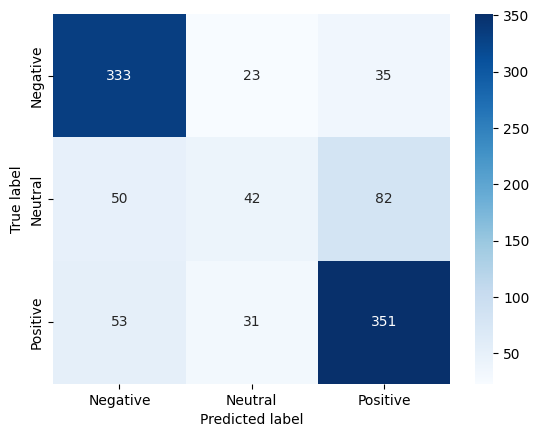

In [9]:
# --- 9. Evaluation ---
classifier.load_state_dict(
    torch.load(f"models/{sample_size}_samples_best_{output_name}_sentiment.bin")
)


def get_predictions(model, loader):
    model.eval()
    predictions, probs, true_labels = [], [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            targets = batch["targets"].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            prob = F.softmax(outputs, dim=1)

            predictions.extend(preds.cpu())
            probs.extend(prob.cpu())
            true_labels.extend(targets.cpu())

    return torch.stack(predictions), torch.stack(probs), torch.stack(true_labels)


y_pred, y_probs, y_true = get_predictions(classifier, test_loader)

print(classification_report(y_true, y_pred, target_names=class_names))


def show_confusion_matrix(cm, class_names):
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


cm = confusion_matrix(y_true, y_pred)
show_confusion_matrix(cm, class_names)